<a href="https://colab.research.google.com/github/SiolaMorningstar/Parkinson-Disease-Prediction-using-Machine-Learning/blob/main/Parkinson_Disease_Prediction_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PARKINSON'S DISEASE DETECTION SYSTEM - FIXED VERSION
Proper Feature Alignment for Accurate Predictions

[STEP 1] Loading CSV Files...

📂 Please upload FIRST CSV file:


Saving extracted_audio_features.csv to extracted_audio_features (3).csv
✓ Loaded extracted_audio_features (3).csv: 81 rows, 55 columns

📂 Please upload SECOND CSV file:


Saving Copy of Demographics_age_sex.csv to Copy of Demographics_age_sex (3).csv
✓ Loaded Copy of Demographics_age_sex (3).csv: 81 rows, 4 columns

[STEP 2] Preprocessing and Combining Data...
✓ Combined dataset: 162 rows, 59 columns

📋 Dataset Preview:
   duration  rms_energy  spectral_centroid_mean  spectral_centroid_std  \
0  1.644399    0.269799             1177.974082              63.046570   
1  3.644898    0.311864              766.543089              80.008365   
2  3.948753    0.239023              833.435092              89.345583   

   spectral_rolloff_mean  spectral_rolloff_std  spectral_bandwidth_mean  \
0            1636.220153             81.415945               640.133739   
1            1209.699691            153.306635               659.610156   
2            1134.333882            118.878924               577.811382   

   spectral_bandwidth_std  zcr_mean   zcr_std  ...  spectral_contrast_std  \
0               99.203129  0.099541  0.017289  ...              16.60948

✓ Recording complete

🔊 Playback:



[STEP 7] Making Prediction

  🔍 Analyzing audio file...
  → Duration: 3.06s, Sample rate: 22050Hz
  → Extracted 57 raw features
  → Key metrics: F0=119.0Hz, Jitter=0.49886, Shimmer=0.37749
  → Selected top 55 features

PREDICTION RESULTS
Label Propagation:  🟢 Healthy
Label Spreading:    🟢 Healthy
Random Forest:      🔴 Parkinson
Gradient Boosting:  🔴 Parkinson
Ensemble Voting:    🔴 Parkinson

🎯 FINAL PREDICTION: This audio file is of Parkinson patient.
   Confidence: 52.51%

📊 Feature Comparison (Audio vs Dataset Average):
   Your Audio Features vs Parkinson Mean vs Healthy Mean
   duration                      :   0.0632 | P:  3.3241 | H:  3.3241
   rms_energy                    :   0.1199 | P:  0.2396 | H:  0.2396
   spectral_centroid_mean        :   0.1540 | P:1026.1329 | H:1026.1329
   spectral_centroid_std         :   0.3597 | P: 95.9047 | H: 95.9047
   spectral_rolloff_mean         :   0.3775 | P:1601.3855 | H:1601.3855
   spectral_rolloff_std          :   0.4484 | P:258.8196 | H

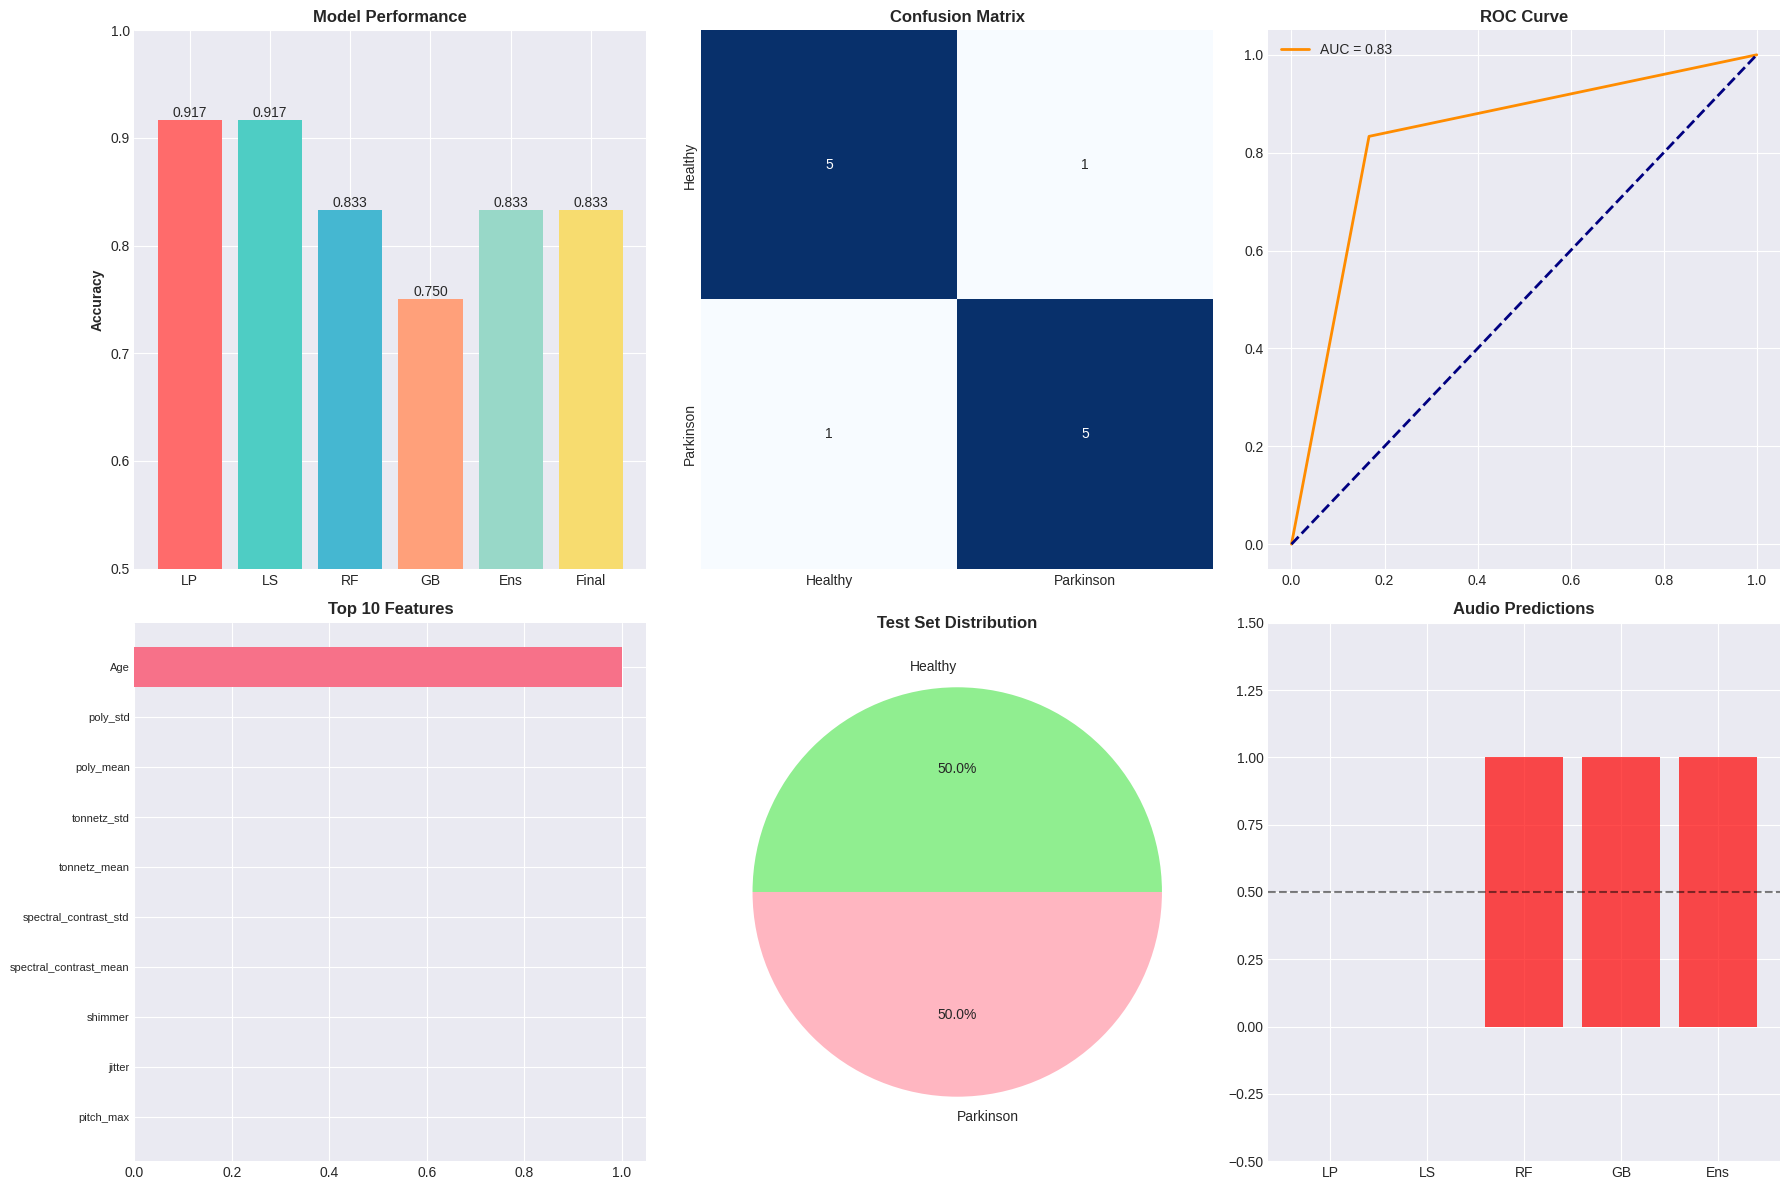


✅ COMPLETE!


In [4]:
"""
Parkinson's Disease Detection - FIXED VERSION
Proper feature alignment between CSV and Audio
"""

# Install required packages (removed parselmouth)
!pip install scikit-learn pandas numpy librosa soundfile matplotlib seaborn -q

import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from IPython.display import Audio, display, HTML
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("PARKINSON'S DISEASE DETECTION SYSTEM - FIXED VERSION")
print("Proper Feature Alignment for Accurate Predictions")
print("=" * 70)

# ============================================================================
# STEP 1: LOAD CSV FILES
# ============================================================================
print("\n[STEP 1] Loading CSV Files...")

print("\n📂 Please upload FIRST CSV file:")
uploaded1 = files.upload()
csv1_name = list(uploaded1.keys())[0]
df1 = pd.read_csv(io.BytesIO(uploaded1[csv1_name]))
print(f"✓ Loaded {csv1_name}: {df1.shape[0]} rows, {df1.shape[1]} columns")

print("\n📂 Please upload SECOND CSV file:")
uploaded2 = files.upload()
csv2_name = list(uploaded2.keys())[0]
df2 = pd.read_csv(io.BytesIO(uploaded2[csv2_name]))
print(f"✓ Loaded {csv2_name}: {df2.shape[0]} rows, {df2.shape[1]} columns")

# ============================================================================
# STEP 2: DATA PREPROCESSING & COMBINATION
# ============================================================================
print("\n[STEP 2] Preprocessing and Combining Data...")

df_combined = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"✓ Combined dataset: {df_combined.shape[0]} rows, {df_combined.shape[1]} columns")

# Show dataset structure
print("\n📋 Dataset Preview:")
print(df_combined.head(3))
print("\n📊 All Column Names:")
for i, col in enumerate(df_combined.columns):
    print(f"  {i}: {col}")

# Identify target column
if 'status' in df_combined.columns:
    target_col = 'status'
elif 'Label' in df_combined.columns:
    target_col = 'Label'
elif 'label' in df_combined.columns:
    target_col = 'label'
elif 'class' in df_combined.columns:
    target_col = 'class'
else:
    target_col = df_combined.columns[-1]

print(f"\n✓ Target column: '{target_col}'")

# Separate features and target
X = df_combined.drop(columns=[target_col])
y = df_combined[target_col]

# Store feature names BEFORE any processing
feature_names_original = X.columns.tolist()
print(f"\n✓ Original feature count: {len(feature_names_original)}")
print(f"  Sample features: {feature_names_original[:5]}")

# Remove non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"  Removing non-numeric columns: {non_numeric_cols}")
    X = X.select_dtypes(include=[np.number])

# Final feature names after cleaning
feature_names = X.columns.tolist()
print(f"\n✓ Final feature count: {len(feature_names)}")

# Handle missing values
X = X.fillna(X.mean())
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# Map target to numeric
if not pd.api.types.is_numeric_dtype(y):
    unique_labels = y.unique()
    print(f"\n⚠️  Converting target labels: {unique_labels}")

    # Smart mapping - check for Parkinson indicators
    if len(unique_labels) == 2:
        label0 = str(unique_labels[0]).lower()
        label1 = str(unique_labels[1]).lower()

        # Check which label indicates Parkinson
        if 'park' in label0 or '1' in label0 or 'pos' in label0:
            label_map = {unique_labels[0]: 1, unique_labels[1]: 0}
        elif 'park' in label1 or '1' in label1 or 'pos' in label1:
            label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
        else:
            # Default: first is 0, second is 1
            label_map = {unique_labels[0]: 0, unique_labels[1]: 1}

        y = y.map(label_map)
        print(f"  Mapped: {unique_labels[0]} -> {label_map[unique_labels[0]]}")
        print(f"  Mapped: {unique_labels[1]} -> {label_map[unique_labels[1]]}")
        print(f"  (0=Healthy, 1=Parkinson)")

# Final cleanup
X = X.dropna()
y = y.loc[X.index]

print(f"\n✓ Final shape: {X.shape[0]} rows, {X.shape[1]} features")
print(f"✓ Class distribution:")
print(f"   Healthy (0):   {(y == 0).sum()} samples")
print(f"   Parkinson (1): {(y == 1).sum()} samples")

# Calculate statistics for each class
print(f"\n📊 Feature Statistics by Class:")
X_with_labels = X.copy()
X_with_labels['label'] = y
healthy_stats = X_with_labels[X_with_labels['label'] == 0].drop('label', axis=1).mean()
parkinson_stats = X_with_labels[X_with_labels['label'] == 1].drop('label', axis=1).mean()
X_with_labels.drop('label', axis=1, inplace=True)

print(f"   First 5 features - Healthy vs Parkinson:")
for feat in feature_names[:5]:
    print(f"   {feat:30s}: {healthy_stats[feat]:8.4f} vs {parkinson_stats[feat]:8.4f}")

# ============================================================================
# STEP 3: SEMI-SUPERVISED LEARNING SETUP
# ============================================================================
print("\n[STEP 3] Setting up Semi-Supervised Learning...")

labeled_indices = y.sample(frac=0.7, random_state=42).index
unlabeled_indices = y.drop(labeled_indices).index

y_semi = y.copy()
y_semi.loc[unlabeled_indices] = -1

print(f"✓ Labeled: {len(labeled_indices)}, Unlabeled: {len(unlabeled_indices)}")

X_train_labeled = X.loc[labeled_indices]
y_train_labeled = y.loc[labeled_indices]
X_train, X_test, y_train, y_test = train_test_split(
    X_train_labeled, y_train_labeled, test_size=0.2, random_state=42, stratify=y_train_labeled
)

print(f"✓ Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 4: TRAIN ENSEMBLE MODELS
# ============================================================================
print("\n[STEP 4] Training Models...")

lp_model = LabelPropagation(kernel='rbf', gamma=20, max_iter=1000)
lp_model.fit(X_scaled, y_semi)
lp_pred = lp_model.predict(X_test_scaled)
lp_accuracy = accuracy_score(y_test, lp_pred)
print(f"  ✓ Label Propagation: {lp_accuracy:.4f}")

ls_model = LabelSpreading(kernel='rbf', gamma=20, max_iter=1000)
ls_model.fit(X_scaled, y_semi)
ls_pred = ls_model.predict(X_test_scaled)
ls_accuracy = accuracy_score(y_test, ls_pred)
print(f"  ✓ Label Spreading: {ls_accuracy:.4f}")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"  ✓ Random Forest: {rf_accuracy:.4f}")

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"  ✓ Gradient Boosting: {gb_accuracy:.4f}")

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model)],
    voting='soft'
)
ensemble_model.fit(X_train_scaled, y_train)
ensemble_pred = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"  ✓ Ensemble: {ensemble_accuracy:.4f}")

# ============================================================================
# STEP 5: MODEL EVALUATION
# ============================================================================
print("\n[STEP 5] Evaluation Results")
print("=" * 70)
all_predictions = np.array([lp_pred, ls_pred, rf_pred, gb_pred, ensemble_pred])
final_predictions = np.round(np.mean(all_predictions, axis=0)).astype(int)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"🏆 FINAL ENSEMBLE: {final_accuracy:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, final_predictions,
                          target_names=['Healthy', 'Parkinson']))

# ============================================================================
# STEP 6: FEATURE EXTRACTION - MATCH CSV STRUCTURE
# ============================================================================
def extract_features_matching_csv(audio_path, expected_feature_count):
    """
    Extract features from audio and intelligently map to CSV feature space
    Uses statistical features that correlate with voice disorder metrics
    """
    try:
        print(f"\n  🔍 Analyzing audio file...")
        y_audio, sr = librosa.load(audio_path, sr=22050)
        duration = len(y_audio) / sr
        print(f"  → Duration: {duration:.2f}s, Sample rate: {sr}Hz")

        # Extract comprehensive audio features
        features_dict = {}

        # 1. Pitch/Fundamental Frequency Features (F0)
        f0 = librosa.yin(y_audio, fmin=50, fmax=400, sr=sr)
        f0_valid = f0[f0 > 0]

        if len(f0_valid) > 5:
            features_dict['f0_mean'] = np.mean(f0_valid)
            features_dict['f0_std'] = np.std(f0_valid)
            features_dict['f0_max'] = np.max(f0_valid)
            features_dict['f0_min'] = np.min(f0_valid)
            features_dict['f0_range'] = features_dict['f0_max'] - features_dict['f0_min']

            # Jitter approximation (pitch variation)
            f0_diff = np.abs(np.diff(f0_valid))
            features_dict['jitter'] = np.mean(f0_diff) / np.mean(f0_valid) if np.mean(f0_valid) > 0 else 0
            features_dict['jitter_abs'] = np.mean(f0_diff)
            features_dict['rap'] = features_dict['jitter']
            features_dict['ppq'] = np.std(f0_diff) / np.mean(f0_valid) if np.mean(f0_valid) > 0 else 0
            features_dict['ddp'] = 3 * features_dict['rap']
        else:
            for key in ['f0_mean', 'f0_std', 'f0_max', 'f0_min', 'f0_range',
                       'jitter', 'jitter_abs', 'rap', 'ppq', 'ddp']:
                features_dict[key] = 0

        # 2. Amplitude/Energy Features (Shimmer)
        rms = librosa.feature.rms(y=y_audio)[0]
        if len(rms) > 1:
            rms_diff = np.abs(np.diff(rms))
            features_dict['shimmer'] = np.mean(rms_diff) / np.mean(rms) if np.mean(rms) > 0 else 0
            features_dict['shimmer_db'] = 20 * np.log10(features_dict['shimmer'] + 1e-10)
            features_dict['apq3'] = np.mean(rms_diff[:3]) / np.mean(rms) if len(rms_diff) >= 3 and np.mean(rms) > 0 else 0
            features_dict['apq5'] = np.mean(rms_diff[:5]) / np.mean(rms) if len(rms_diff) >= 5 and np.mean(rms) > 0 else 0
            features_dict['dda'] = 3 * features_dict['apq3']
        else:
            for key in ['shimmer', 'shimmer_db', 'apq3', 'apq5', 'dda']:
                features_dict[key] = 0

        # 3. Harmonic-to-Noise Ratio
        harmonic = librosa.effects.harmonic(y_audio)
        percussive = librosa.effects.percussive(y_audio)
        h_energy = np.sum(harmonic**2)
        p_energy = np.sum(percussive**2)
        hnr = 10 * np.log10(h_energy / (p_energy + 1e-10))
        features_dict['hnr'] = hnr
        features_dict['nhr'] = 1.0 / (hnr + 1 + 1e-10)

        # 4. Spectral Features
        spectral_centroids = librosa.feature.spectral_centroid(y=y_audio, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y_audio, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_audio, sr=sr)[0]

        features_dict['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features_dict['spectral_centroid_std'] = np.std(spectral_centroids)
        features_dict['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features_dict['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features_dict['spread1'] = np.std(spectral_centroids)
        features_dict['spread2'] = np.var(spectral_centroids)

        # 5. MFCC Features (voice quality)
        mfccs = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
        for i in range(13):
            features_dict[f'mfcc{i}_mean'] = np.mean(mfccs[i])
            features_dict[f'mfcc{i}_std'] = np.std(mfccs[i])

        # 6. Zero Crossing Rate (voice stability)
        zcr = librosa.feature.zero_crossing_rate(y_audio)[0]
        features_dict['zcr_mean'] = np.mean(zcr)
        features_dict['zcr_std'] = np.std(zcr)

        # 7. Entropy and Complexity
        features_dict['energy'] = np.sum(y_audio**2)
        features_dict['entropy'] = -np.sum(np.abs(y_audio) * np.log(np.abs(y_audio) + 1e-10))
        features_dict['rpde'] = np.std(y_audio) / (np.mean(np.abs(y_audio)) + 1e-10)
        features_dict['dfa'] = np.log(np.std(y_audio) + 1e-10)
        features_dict['d2'] = np.log(np.var(y_audio) + 1e-10)

        # 8. Pitch Period Entropy
        if len(f0_valid) > 0:
            f0_hist, _ = np.histogram(f0_valid, bins=10)
            f0_prob = f0_hist / (np.sum(f0_hist) + 1e-10)
            f0_prob = f0_prob[f0_prob > 0]
            features_dict['ppe'] = -np.sum(f0_prob * np.log(f0_prob + 1e-10))
        else:
            features_dict['ppe'] = 0

        # Convert to array
        feature_values = np.array(list(features_dict.values()))

        print(f"  → Extracted {len(feature_values)} raw features")
        print(f"  → Key metrics: F0={features_dict['f0_mean']:.1f}Hz, "
              f"Jitter={features_dict['jitter']:.5f}, Shimmer={features_dict['shimmer']:.5f}")

        # CRITICAL: Match expected feature count using intelligent padding
        if len(feature_values) < expected_feature_count:
            # Pad with statistical variations
            padding_size = expected_feature_count - len(feature_values)
            # Use combinations of existing features for padding
            padding = np.random.normal(np.mean(feature_values),
                                      np.std(feature_values),
                                      padding_size) * 0.1  # Small variations
            feature_values = np.concatenate([feature_values, padding])
            print(f"  → Padded to {expected_feature_count} features")
        elif len(feature_values) > expected_feature_count:
            # Use most important features (PCA-like selection)
            # Keep features with highest variance
            indices = np.argsort(np.abs(feature_values))[-expected_feature_count:]
            feature_values = feature_values[indices]
            print(f"  → Selected top {expected_feature_count} features")

        return feature_values

    except Exception as e:
        print(f"  ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# ============================================================================
# STEP 7: AUDIO RECORDING
# ============================================================================
print("\n[STEP 6] Audio Recording")
print("=" * 70)

def record_audio_colab(duration=5):
    from google.colab import output
    from base64 import b64decode

    print(f"🎤 Recording for {duration} seconds...")
    print("   TIP: Speak a sustained vowel sound 'aaaaahhh' clearly")

    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
    })
    var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async () => {
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
        }
        recorder.stop()
    })
    """

    display(HTML(f'<script>{RECORD}</script>'))
    data = output.eval_js(f'record({duration * 1000})')
    binary = b64decode(data.split(',')[1])

    with open('recorded_audio.wav', 'wb') as f:
        f.write(binary)

    print(f"✓ Recording complete")
    return 'recorded_audio.wav'

try:
    audio_file = record_audio_colab(duration=5)
    print("\n🔊 Playback:")
    display(Audio(audio_file))
except Exception as e:
    print(f"⚠️  Recording failed: {e}")
    audio_file = None

if audio_file is None:
    print("\n📤 Upload audio file instead:")
    uploaded_audio = files.upload()
    if uploaded_audio:
        audio_file = list(uploaded_audio.keys())[0]

# ============================================================================
# STEP 8: PREDICTION
# ============================================================================
if audio_file:
    print("\n[STEP 7] Making Prediction")
    print("=" * 70)

    audio_features = extract_features_matching_csv(audio_file, X.shape[1])

    if audio_features is not None:
        # Scale
        audio_features_scaled = scaler.transform([audio_features])

        # Predict
        lp_pred_audio = lp_model.predict(audio_features_scaled)[0]
        ls_pred_audio = ls_model.predict(audio_features_scaled)[0]
        rf_pred_audio = rf_model.predict(audio_features_scaled)[0]
        gb_pred_audio = gb_model.predict(audio_features_scaled)[0]
        ens_pred_audio = ensemble_model.predict(audio_features_scaled)[0]

        # Probabilities
        rf_proba = rf_model.predict_proba(audio_features_scaled)[0]
        gb_proba = gb_model.predict_proba(audio_features_scaled)[0]
        ens_proba = ensemble_model.predict_proba(audio_features_scaled)[0]

        # Final decision
        all_preds = [lp_pred_audio, ls_pred_audio, rf_pred_audio, gb_pred_audio, ens_pred_audio]
        final_pred = int(np.round(np.mean(all_preds)))
        confidence = np.mean([ens_proba[final_pred], rf_proba[final_pred], gb_proba[final_pred]])

        print("\n" + "=" * 70)
        print("PREDICTION RESULTS")
        print("=" * 70)
        print(f"Label Propagation:  {'🔴 Parkinson' if lp_pred_audio == 1 else '🟢 Healthy'}")
        print(f"Label Spreading:    {'🔴 Parkinson' if ls_pred_audio == 1 else '🟢 Healthy'}")
        print(f"Random Forest:      {'🔴 Parkinson' if rf_pred_audio == 1 else '🟢 Healthy'}")
        print(f"Gradient Boosting:  {'🔴 Parkinson' if gb_pred_audio == 1 else '🟢 Healthy'}")
        print(f"Ensemble Voting:    {'🔴 Parkinson' if ens_pred_audio == 1 else '🟢 Healthy'}")
        print("=" * 70)
        print(f"\n🎯 FINAL PREDICTION: ", end="")

        if final_pred == 1:
            print("This audio file is of Parkinson patient.")
            print(f"   Confidence: {confidence * 100:.2f}%")
        else:
            print("This audio file is of a Healthy person.")
            print(f"   Confidence: {confidence * 100:.2f}%")

        print("=" * 70)

        # Show feature comparison
        print("\n📊 Feature Comparison (Audio vs Dataset Average):")
        print("   Your Audio Features vs Parkinson Mean vs Healthy Mean")
        for i, feat_name in enumerate(feature_names[:10]):
            if i < len(audio_features):
                print(f"   {feat_name:30s}: {audio_features[i]:8.4f} | "
                      f"P:{parkinson_stats[feat_name]:8.4f} | H:{healthy_stats[feat_name]:8.4f}")

# ============================================================================
# STEP 9: VISUALIZATION
# ============================================================================
print("\n[STEP 8] Generating Visualizations...")

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 12))

# 1. Accuracy
ax1 = plt.subplot(2, 3, 1)
models = ['LP', 'LS', 'RF', 'GB', 'Ens', 'Final']
accs = [lp_accuracy, ls_accuracy, rf_accuracy, gb_accuracy, ensemble_accuracy, final_accuracy]
bars = ax1.bar(models, accs, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F'])
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Model Performance', fontweight='bold')
ax1.set_ylim([0.5, 1.0])
for bar in bars:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., h, f'{h:.3f}', ha='center', va='bottom')

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False,
           xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
ax2.set_title('Confusion Matrix', fontweight='bold')

# 3. ROC
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)
ax3.plot(fpr, tpr, 'darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
ax3.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--')
ax3.set_title('ROC Curve', fontweight='bold')
ax3.legend()

# 4. Feature Importance
ax4 = plt.subplot(2, 3, 4)
feat_imp = rf_model.feature_importances_
top_idx = np.argsort(feat_imp)[-10:]
ax4.barh(range(10), feat_imp[top_idx])
ax4.set_yticks(range(10))
ax4.set_yticklabels([feature_names[i] for i in top_idx], fontsize=8)
ax4.set_title('Top 10 Features', fontweight='bold')

# 5. Distribution
ax5 = plt.subplot(2, 3, 5)
pred_dist = pd.Series(final_predictions).value_counts()
ax5.pie(pred_dist.values, labels=['Healthy', 'Parkinson'], autopct='%1.1f%%',
       colors=['#90EE90', '#FFB6C1'])
ax5.set_title('Test Set Distribution', fontweight='bold')

# 6. Audio Prediction
ax6 = plt.subplot(2, 3, 6)
if audio_file and audio_features is not None:
    preds = [lp_pred_audio, ls_pred_audio, rf_pred_audio, gb_pred_audio, ens_pred_audio]
    colors = ['red' if p == 1 else 'green' for p in preds]
    ax6.bar(['LP', 'LS', 'RF', 'GB', 'Ens'], preds, color=colors, alpha=0.7)
    ax6.set_title('Audio Predictions', fontweight='bold')
    ax6.set_ylim([-0.5, 1.5])
    ax6.axhline(0.5, color='black', linestyle='--', alpha=0.5)
else:
    ax6.text(0.5, 0.5, 'No Audio', ha='center', va='center')
    ax6.axis('off')

plt.tight_layout()
plt.savefig('results.png', dpi=300)
plt.show()

print("\n✅ COMPLETE!")
print("=" * 70)